在模型更新的时间点（如1年更新一次），运行以下步骤：
- 【筛选因子】利用历史数据（如2年），计算因子IC分数（同时考虑IC均值（绝对值尽量大）与IC标准差（尽量小）），筛选因子
- 【训练模型】生成训练集，预处理数据（去空值、去极值、标准化、PCA），训练模型，挑选最优参数模型
- 【实时预测】生成测试集，预处理数据，实时预测未来表现，填充alpha矩阵

## 导入相关库（必须运行）

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

from JuRunPlatform import StrategyPlatform

InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


## 全局变量（必须运行）

In [2]:
stock_file = '../stockset/ashare_tradable.csv'  # 股票池
benchmark = '000905.SH'               # 基准
train_years = 2                       # 训练数据长度
update_years = 1                      # 模型更新频率
reallocate_days = 10                  # 调仓频率
max_hold_num = 20                     # 最大持仓个数
ic_value_w = 0.7                      # IC值权重
factor_num = 50                       # 筛选出的因子个数
min_non_nan = 0.3                     # 去除空值时最小非空值比例
min_sample = 0.5                      # 去除空值后最小样本比例

class DropExtreme(TransformerMixin):
    """
    中位数去极值
    """
    def __init__(self):
        self.high = None
        self.low = None
        
    def fit(self, X):
        Dm = X.median()
        Dm1 = (X - Dm).abs().median()
        self.high = Dm + 5 * Dm1
        self.low = Dm - 5 * Dm1
    
    def transform(self, X):
        column_list = X.columns
        X = pd.DataFrame(np.where(X > self.high, self.high, X), columns=column_list)
        return pd.DataFrame(np.where(X < self.low, self.low, X), columns=column_list)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
def get_factor(factor, agent):
    """
    获取因子值
    """
    return [factor, agent.LoadData("ashare", factor)]

def save_factor(factor_list, year):
    """
    保存因子列表
    """
    with open('data/factor_%d.txt' % year, 'w') as f:
        f.write('\n'.join(factor_list))

def load_factor(year):
    """
    加载因子列表
    """
    with open('data/factor_%d.txt' % year, 'r') as f:
        factor_list = f.read().split('\n')
    return factor_list

def save_model(model, name):
    """
    保存模型
    """
    with open('model/%s.pkl' % name, 'wb') as f:
        pickle.dump(model, f)

def load_model(name):
    """
    加载模型
    """
    with open('model/%s.pkl' % name, 'rb') as f:
        model = pickle.load(f)
    return model

def load_data(year):
    """
    加载数据
    """
    train_set = pd.read_csv('data/train_%d.csv' % year)
    test_set = pd.read_csv('data/test_%d.csv' % year)
    X_train = train_set.drop(columns=['y'])
    y_train = train_set['y'].values
    X_test = test_set.drop(columns=['y'])
    y_test = test_set['y'].values
    return X_train, y_train, X_test, y_test

## 筛选因子

In [3]:
class FactorFilter:
    """
    因子筛选器
    """
    def __init__(self, _stock_agent, _index_agent, _benchmark, _reallocate_days, 
                 _ic_value_w, _factor_num, _min_non_nan, _min_sample):
        self.stock_agent = _stock_agent          # 股票agent
        self.index_agent = _index_agent          # 指数agent
        self.benchmark = _benchmark              # 基准
        self.reallocate_days = _reallocate_days  # 调仓频率
        self.ic_value_w = _ic_value_w            # IC值权重
        self.factor_num = _factor_num            # 筛选出的因子个数
        self.min_non_nan = _min_non_nan          # 去除空值时最小非空值比例
        self.min_sample = _min_sample            # 去除空值后最小样本比例
        
    def get_ic(self, factor, ret_df):
        """
        计算IC
        factor：因子名称
        ret_df：收益率DataFrame
        """
        factor_df = self.stock_agent.LoadData("ashare", factor)[::self.reallocate_days]
        factor_df.dropna(thresh=factor_df.shape[1] * self.min_non_nan, inplace=True)
        if factor_df.shape[0] < ret_df.shape[0] * self.min_sample:
            abs_mean_ic = np.nan
            std_ic = np.nan
            direction = np.nan
        else:
            ic = factor_df.corrwith(ret_df, axis=1, drop=True, method='spearman')
            mean_ic = ic.mean()
            abs_mean_ic = abs(mean_ic)
            std_ic = ic.std()
            direction = 1 if mean_ic > 0 else -1
        return {
            'factor': factor,
            'abs_mean_ic': round(abs_mean_ic, 4),
            'std_ic': round(std_ic, 4),
            'direction': direction
        }
    
    def get_ic_score(self):
        """
        计算IC分数（综合IC均值与IC标准差）
        """
        factor_list = self.stock_agent.GetFactorList('ashare')['Name'].values
        stock_price_df = self.stock_agent.LoadData("ashare", "S_DQ_CLOSE")[::self.reallocate_days]
        index_price_df = self.index_agent.LoadData("aindex", "S_DQ_CLOSE")[::self.reallocate_days]
        ret_df = (stock_price_df.shift(-1) / stock_price_df).sub((index_price_df.shift(-1) / index_price_df)[self.benchmark], 0)
        score_list = Parallel(n_jobs=-1, verbose=5)(delayed(self.get_ic)(factor, ret_df) for factor in factor_list)
        score_df = pd.DataFrame(score_list)
        score_df.dropna(inplace=True)
        score_df['ic_score'] = round(score_df['abs_mean_ic'].rank() * self.ic_value_w + \
                               score_df['std_ic'].rank(ascending=False) * (1 - self.ic_value_w), 4)
        score_df.sort_values(by='ic_score', ascending=False, inplace=True)
        score_df.reset_index(drop=True, inplace=True)
        return score_df
    
start_year = 2013
end_year = 2019
for cur_year in range(start_year, end_year + 1, update_years):
    train_start = int(str(cur_year - train_years) + '0101')
    train_end = int(str(cur_year - 1) + '1231')
    print(train_start, train_end)
    stock_agent = StrategyPlatform()
    stock_agent.SetStockListByCSVFile(stock_file)
    stock_agent.SetDate(train_start, train_end)
    index_agent = StrategyPlatform()
    index_agent.SetStockList([benchmark])
    index_agent.SetDate(train_start, train_end)
    ff = FactorFilter(stock_agent, index_agent, benchmark, reallocate_days, 
                      ic_value_w, factor_num, min_non_nan, min_sample)
    score_df = ff.get_ic_score()
    factor_list = score_df['factor'].values[:factor_num]
    save_factor(factor_list, cur_year)

20180101 20191231
loading S_DQ_CLOSE [20180102,20191231]
loading S_DQ_CLOSE [20180102,20191231]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1479 out of 1479 | elapsed:  7.5min finished


## 准备数据

In [4]:
def get_dataset(stock_agent, index_agent, benchmark, factor_list, reallocate_days):
    """
    获取数据集
    """
    dataset = pd.DataFrame()
    stock_price_df = stock_agent.LoadData("ashare", "S_DQ_CLOSE")[::reallocate_days]
    index_price_df = index_agent.LoadData("aindex", "S_DQ_CLOSE")[::reallocate_days]
    ret_df = (stock_price_df.shift(-1) / stock_price_df).sub((index_price_df.shift(-1) / index_price_df)[benchmark], 0)
    ret_array = ret_df.values.ravel()
    pct_low = np.nanpercentile(ret_array, 30)
    pct_high = np.nanpercentile(ret_array, 70)
    print(round(pct_low, 4), round(pct_high, 4))
    idx_low = np.where(ret_array < pct_low)[0]
    idx_high = np.where(ret_array > pct_high)[0]
    idx_nan = list(set(range(len(ret_array))) - set(idx_low) - set(idx_high))
    ret_array[idx_high] = 1
    ret_array[idx_low] = 0
    ret_array[idx_nan] = np.nan
    dataset['y'] = ret_array
    factor_value_list = Parallel(n_jobs=-1, verbose=10)(delayed(get_factor)(factor, stock_agent) for factor in factor_list)
    for v in factor_value_list:
        dataset[v[0]] = v[1][::reallocate_days].values.ravel()
    dataset.dropna(inplace=True)
    return dataset

def get_data(cur_year, factor_list):
    """
    获取训练集、测试集
    """
    train_start = int(str(cur_year - train_years) + '0101')
    train_end = int(str(cur_year - 1) + '1231')
    test_start = int(str(cur_year) + '0101')
    test_end = int(str(cur_year + update_years - 1) + '1231')
    print(train_start, train_end, test_start, test_end)
    # 训练集
    stock_agent = StrategyPlatform()
    stock_agent.SetStockListByCSVFile(stock_file)
    stock_agent.SetDate(train_start, train_end)
    index_agent = StrategyPlatform()
    index_agent.SetStockList([benchmark])
    index_agent.SetDate(train_start, train_end)
    train_set = get_dataset(stock_agent, index_agent, benchmark, factor_list, reallocate_days)
    # 测试集
    stock_agent.SetDate(test_start, test_end)
    index_agent.SetDate(test_start, test_end)
    test_set = get_dataset(stock_agent, index_agent, benchmark, factor_list, reallocate_days)
    return train_set, test_set

start_year = 2013
end_year = 2019
for cur_year in range(start_year, end_year + 1, update_years):
    factor_list = load_factor(cur_year)
    train_set, test_set = get_data(cur_year, factor_list)
    # 保存
    train_set.to_csv('data/train_%d.csv' % cur_year, index=False)
    test_set.to_csv('data/test_%d.csv' % cur_year, index=False)

20180101 20191231 20200101 20201231
loading S_DQ_CLOSE [20180102,20191231]
loading S_DQ_CLOSE [20180102,20191231]
-0.0301 0.0206


/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   34.0s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   39.8s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   49.5s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   53.6s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   56.5s finished


loading S_DQ_CLOSE [20200102,20200424]
loading S_DQ_CLOSE [20200102,20200424]
-0.0454 0.0248


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   32.7s remaining:   32.7s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   38.2s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   43.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   47.2s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.5s finished


## 训练模型

In [5]:
def train_model(X_train, y_train, X_test, y_test):
    """
    训练模型
    """
    model = Sequential()
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
    return model, hist
    
start_year = 2013
end_year = 2019
for cur_year in range(start_year, end_year + 1, update_years):
    X_train, y_train, X_test, y_test = load_data(cur_year)
    print(cur_year, X_train.shape, X_test.shape)
    # 预处理
    pipeline = Pipeline([
        ('drop_extreme', DropExtreme()),  # 中位数去极值
        ('std_scaler', StandardScaler()),  # 标准化
        ('pca', PCA())  # 主成分分析
    ])
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)
    # 训练
    model, hist = train_model(X_train, y_train, X_test, y_test)
    # 保存
    save_model(pipeline, 'pipeline_%d' % cur_year)
    save_model(model, 'ann_%d' % cur_year)

2020 (93658, 50) (12008, 50)
Train on 93658 samples, validate on 12008 samples
Epoch 1/5
93658/93658 [==============================] - 148s 2ms/step - loss: 0.6780 - accuracy: 0.5692 - val_loss: 0.6846 - val_accuracy: 0.5488
Epoch 2/5
93658/93658 [==============================] - 142s 2ms/step - loss: 0.6689 - accuracy: 0.5828 - val_loss: 0.6937 - val_accuracy: 0.5402
Epoch 3/5
93658/93658 [==============================] - 139s 1ms/step - loss: 0.6644 - accuracy: 0.5908 - val_loss: 0.6944 - val_accuracy: 0.5381
Epoch 4/5
93658/93658 [==============================] - 127s 1ms/step - loss: 0.6608 - accuracy: 0.5963 - val_loss: 0.6998 - val_accuracy: 0.5347
Epoch 5/5
93658/93658 [==============================] - 141s 2ms/step - loss: 0.6582 - accuracy: 0.6000 - val_loss: 0.7007 - val_accuracy: 0.5330


## 填充alpha矩阵

In [3]:
def get_alpha(strategy_agent, factor_list, pipeline, model):
    """
    alpha矩阵
    """
    factor_dict = {}
    factor_value_list = Parallel(n_jobs=-1, verbose=5)(delayed(get_factor)(factor, strategy_agent) for factor in factor_list)
    alpha = np.full(strategy_agent.LoadZeroAlpha().shape, np.nan)
    alpha[0, :] = 0
    for i in range(1, alpha.shape[0], reallocate_days):
        X_cur = pd.DataFrame()
        for v in factor_value_list:
            X_cur[v[0]] = v[1].iloc[i - 1, :]
        X_cur.reset_index(drop=True, inplace=True)
        idx = X_cur.index
        X_cur.dropna(inplace=True)
        non_nan_idx = X_cur.index
        nan_idx = list(set(idx) - set(non_nan_idx))
        X_cur = pipeline.transform(X_cur)
        y_cur_pred = model.predict(X_cur)[:, 1]
        zero_idx = np.argsort(y_cur_pred)[:len(y_cur_pred) - max_hold_num]
        y_cur_pred[zero_idx] = 0
        alpha[i, non_nan_idx] = y_cur_pred / y_cur_pred.sum()
        alpha[i, nan_idx] = 0
    alpha = pd.DataFrame(alpha).ffill().values
    return alpha

start_year = 2013
end_year = 2019
alpha = None
for cur_year in range(start_year, end_year + 1, update_years):
    factor_list = load_factor(cur_year)
    pipeline = load_model('pipeline_%d' % cur_year)
    model = load_model('ann_%d' % cur_year)
    bt_start = int(str(cur_year) + '0101')
    bt_end = int(str(cur_year + update_years - 1) + '1231')
    strategy_agent = StrategyPlatform()
    strategy_agent.SetStockListByCSVFile(stock_file)
    strategy_agent.SetDate(bt_start, bt_end)
    cur_alpha = get_alpha(strategy_agent, factor_list, pipeline, model)
    if alpha is None:
        alpha = cur_alpha
    else:
        alpha = np.vstack((alpha, cur_alpha))
np.savetxt('data/alpha.txt', alpha)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   13.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   11.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   11.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 

<Figure size 1152x432 with 0 Axes>

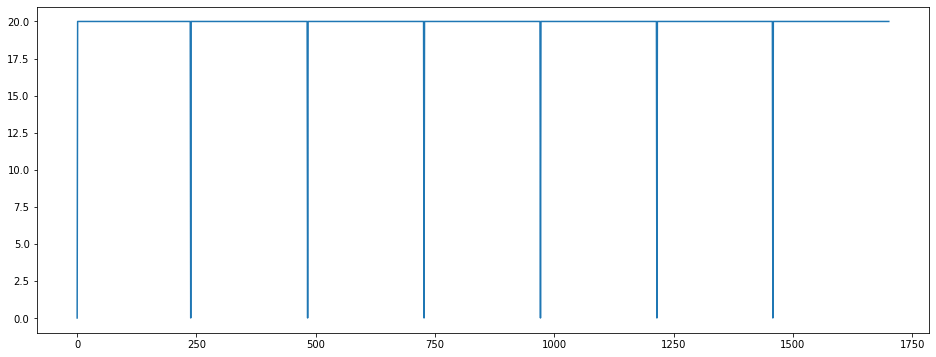

In [4]:
# 每日持仓个数
plt.figure(figsize=(16, 6))
plt.plot((alpha > 0).sum(1))

## 回测

In [3]:
start_date = 20130101
end_date = 20191231
alpha = np.loadtxt('data/alpha.txt')
strategy_agent = StrategyPlatform()
strategy_agent.SetStockListByCSVFile(stock_file)
strategy_agent.SetDate(start_date, end_date)
strategy_agent.GeneratePerformanceAshare(alpha, display=True)

loading S_DQ_CLOSE [20130104,20191231]
loading S_DQ_ADJCLOSE [20130104,20191231]
loading S_DQ_LOW [20130104,20191231]
loading S_DQ_HIGH [20130104,20191231]
loading S_DQ_ADJOPEN [20130104,20191231]
loading S_DQ_OPEN [20130104,20191231]
loading S_DQ_TRADESTATUS_SIG [20130104,20191231]
loading S_DQ_PRECLOSE [20130104,20191231]
loading S_DQ_ADJPRECLOSE [20130104,20191231]


100%|██████████| 1701/1701 [00:21<00:00, 77.41it/s] 


+------------+------------+------------+------------+------------+------------+------------+----------------+--------------+
|  回测收益  |  多头年化  |  基准年化  |  多头夏普  |  最大回撤  |  超额年化  |  超额夏普  |  超额最大回撤  |  日均换手率  |
+------------+------------+------------+------------+------------+------------+------------+----------------+--------------+
|  227.24%   |   32.71%   |   10.56%   |    1.11    |  -21.96%   |   22.15%   |    1.83    |    -15.91%     |    20.17%    |
+------------+------------+------------+------------+------------+------------+------------+----------------+--------------+
